<center> <img src="https://i.imgur.com/jCH5JgT.png"  width="800px" height="300px">

## <center>Classificator of Tweets by emotions
----------------------------
Members

+ José Jaime Silva Martinez - 2183075
+ Yuri Melissa Garcia Niño - 2182697
+ Jhan Eduardo Rojas - 2182690

# Table of Contents

*   <a href="#import_libraries">Import libraries and load the dataset<a/>
    * <a href="#dataset_statistics">Dataset Statistics<a/>
    * <a href="#utilities">Utilities<a/>
    * <a href="#text_preprocessing">Text preprocessing<a/>
    * <a href="#feature_extraction">Feature extraction</a>
* <a href="#models_pergender">Models</a>
    * <a href="#deep_learning">Deep Learning<a/>
    * <a href="#svc">Support Vector Machine<a/>
    * <a href="#rf">Random Forest<a/>
    * <a href="#lr">Logistic Regression<a/>
* <a href="#testing_predictions">Testing and Predictions<a/>
    * <a href="#playground">Playground<a/>

# Set Up

<a name="import_libraries"></a>
## Import libraries and load the dataset


In [1]:
#@title Import libraries and load the dataset
#@markdown The chosen dataset has two columns, `text` (content of the tweet) and `label`, a number between 0 and 5 that represents an emotion. Here are the six basics considered:

#@markdown *   Sadness
#@markdown *   Joy
#@markdown *   Love
#@markdown *   Anger
#@markdown *   Fear
#@markdown *   Surprise

#@markdown Source of dataset: https://www.kaggle.com/parulpandey/emotion-dataset?select=training.csv

# ML
import tensorflow as tf
from tensorflow import keras
import numpy as np
import pandas as pd

# plotting
import matplotlib.pyplot as plt
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns

import nltk
from nltk.corpus import stopwords
nltk.download("stopwords")
STOP_WORDS = set(stopwords.words("english"))

sns.set(style='whitegrid', palette='muted', font_scale=1.2)
PALETTE = ["#003f5c", "#444e86", "#955196", "#dd5182", "#ff6e54", "#ffa600"]
sns.set_palette(sns.color_palette(PALETTE))

NUM_CLASSES = 6
EMOTIONS_MAP = {
  0: "sadness",
  1: "joy",
  2: "love",
  3: "anger",
  4: "fear",
  5: "surprise"
}

LINK_DATASET_TRAINING = 'https://drive.google.com/uc?id=186JB1cJuBQV2JddKYUQYCHzORaSCO7zG'
LINK_DATASET_TEST = 'https://drive.google.com/uc?id=18rm4txveuyXUcdYB6_c2NuuqKd_n-xGz'

tweet_emotions_training = pd.read_csv(LINK_DATASET_TRAINING, delimiter=',')
tweet_emotions_test = pd.read_csv(LINK_DATASET_TEST, delimiter=',')

# add an aditional column with the label text
tweet_emotions_training['emotion'] = tweet_emotions_training['label'].map(EMOTIONS_MAP)
tweet_emotions_test['emotion'] = tweet_emotions_test['label'].map(EMOTIONS_MAP)

tweet_emotions_training.head()

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


,text,label,emotion
0,i didnt feel humiliated,0,sadness
1,i can go from feeling so hopeless to so damned...,0,sadness
2,im grabbing a minute to post i feel greedy wrong,3,anger
3,i am ever feeling nostalgic about the fireplac...,2,love
4,i am feeling grouchy,3,anger


<a name="utilities"></a>
## Utilities

In [2]:
from matplotlib.cbook import strip_math
def to_percent(value: float, n_decimals=4) -> float:
  """ turn value into percentage """
  return round(value * 100, n_decimals)

def plot_history(history, title: str):
    acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']
    loss = history.history['loss']
    val_loss = history.history['val_loss']
    x = range(1, len(acc) + 1)

    fig = plt.figure(figsize=(12, 5))
    ax = plt.subplot(1, 2, 1)
    plt.plot(x, acc, 'b', label='Training acc')
    plt.plot(x, val_acc, 'r', label='Validation acc')
    ax.set_title("Training and validation accuracy")
    plt.legend()
    ax = plt.subplot(1, 2, 2)
    plt.plot(x, loss, 'b', label='Training loss')
    plt.plot(x, val_loss, 'r', label='Validation loss')
    ax.set_title('Training and validation loss')
    plt.legend()
    fig.suptitle(title)


<a name="text_preprocessing"></a>
## Text Preprocessing

In [3]:
import re, string

abbreviations = {
        "$" : " dollar ",
        "€" : " euro ",
        "4ao" : "for adults only",
        "a.m" : "before midday",
        "a3" : "anytime anywhere anyplace",
        "aamof" : "as a matter of fact",
        "acct" : "account",
        "adih" : "another day in hell",
        "afaic" : "as far as i am concerned",
        "afaict" : "as far as i can tell",
        "afaik" : "as far as i know",
        "afair" : "as far as i remember",
        "afk" : "away from keyboard",
        "app" : "application",
        "approx" : "approximately",
        "apps" : "applications",
        "asap" : "as soon as possible",
        "asl" : "age, sex, location",
        "atk" : "at the keyboard",
        "ave." : "avenue",
        "aymm" : "are you my mother",
        "ayor" : "at your own risk", 
        "b&b" : "bed and breakfast",
        "b+b" : "bed and breakfast",
        "b.c" : "before christ",
        "b2b" : "business to business",
        "b2c" : "business to customer",
        "b4" : "before",
        "b4n" : "bye for now",
        "b@u" : "back at you",
        "bae" : "before anyone else",
        "bak" : "back at keyboard",
        "bbbg" : "bye bye be good",
        "bbc" : "british broadcasting corporation",
        "bbias" : "be back in a second",
        "bbl" : "be back later",
        "bbs" : "be back soon",
        "be4" : "before",
        "bfn" : "bye for now",
        "blvd" : "boulevard",
        "bout" : "about",
        "brb" : "be right back",
        "bros" : "brothers",
        "brt" : "be right there",
        "bsaaw" : "big smile and a wink",
        "btw" : "by the way",
        "bwl" : "bursting with laughter",
        "c/o" : "care of",
        "cet" : "central european time",
        "cf" : "compare",
        "cia" : "central intelligence agency",
        "csl" : "can not stop laughing",
        "cu" : "see you",
        "cul8r" : "see you later",
        "cv" : "curriculum vitae",
        "cwot" : "complete waste of time",
        "cya" : "see you",
        "cyt" : "see you tomorrow",
        "dae" : "does anyone else",
        "dbmib" : "do not bother me i am busy",
        "diy" : "do it yourself",
        "dm" : "direct message",
        "dwh" : "during work hours",
        "e123" : "easy as one two three",
        "eet" : "eastern european time",
        "eg" : "example",
        "embm" : "early morning business meeting",
        "encl" : "enclosed",
        "encl." : "enclosed",
        "etc" : "and so on",
        "faq" : "frequently asked questions",
        "fawc" : "for anyone who cares",
        "fb" : "facebook",
        "fc" : "fingers crossed",
        "fig" : "figure",
        "fimh" : "forever in my heart", 
        "ft." : "feet",
        "ft" : "featuring",
        "ftl" : "for the loss",
        "ftw" : "for the win",
        "fwiw" : "for what it is worth",
        "fyi" : "for your information",
        "g9" : "genius",
        "gahoy" : "get a hold of yourself",
        "gal" : "get a life",
        "gcse" : "general certificate of secondary education",
        "gfn" : "gone for now",
        "gg" : "good game",
        "gl" : "good luck",
        "glhf" : "good luck have fun",
        "gmt" : "greenwich mean time",
        "gmta" : "great minds think alike",
        "gn" : "good night",
        "g.o.a.t" : "greatest of all time",
        "goat" : "greatest of all time",
        "goi" : "get over it",
        "gps" : "global positioning system",
        "gr8" : "great",
        "gratz" : "congratulations",
        "gyal" : "girl",
        "h&c" : "hot and cold",
        "hp" : "horsepower",
        "hr" : "hour",
        "hrh" : "his royal highness",
        "ht" : "height",
        "ibrb" : "i will be right back",
        "ic" : "i see",
        "icq" : "i seek you",
        "icymi" : "in case you missed it",
        "idc" : "i do not care",
        "idgadf" : "i do not give a damn fuck",
        "idgaf" : "i do not give a fuck",
        "idk" : "i do not know",
        "ie" : "that is",
        "i.e" : "that is",
        "ifyp" : "i feel your pain",
        "ig" : "instagram",
        "iirc" : "if i remember correctly",
        "ilu" : "i love you",
        "ily" : "i love you",
        "imho" : "in my humble opinion",
        "imo" : "in my opinion",
        "imu" : "i miss you",
        "iow" : "in other words",
        "irl" : "in real life",
        "j4f" : "just for fun",
        "jic" : "just in case",
        "jk" : "just kidding",
        "jsyk" : "just so you know",
        "l8r" : "later",
        "lb" : "pound",
        "lbs" : "pounds",
        "ldr" : "long distance relationship",
        "lmao" : "laugh my ass off",
        "lmfao" : "laugh my fucking ass off",
        "lol" : "laughing out loud",
        "ltd" : "limited",
        "ltns" : "long time no see",
        "m8" : "mate",
        "mf" : "motherfucker",
        "mfs" : "motherfuckers",
        "mfw" : "my face when",
        "mofo" : "motherfucker",
        "mph" : "miles per hour",
        "mr" : "mister",
        "mrw" : "my reaction when",
        "ms" : "miss",
        "mte" : "my thoughts exactly",
        "nagi" : "not a good idea",
        "nbc" : "national broadcasting company",
        "nbd" : "not big deal",
        "nfs" : "not for sale",
        "ngl" : "not going to lie",
        "nhs" : "national health service",
        "nrn" : "no reply necessary",
        "nsfl" : "not safe for life",
        "nsfw" : "not safe for work",
        "nth" : "nice to have",
        "nvr" : "never",
        "nyc" : "new york city",
        "oc" : "original content",
        "og" : "original",
        "ohp" : "overhead projector",
        "oic" : "oh i see",
        "omdb" : "over my dead body",
        "omg" : "oh my god",
        "omw" : "on my way",
        "p.a" : "per annum",
        "p.m" : "after midday",
        "pm" : "prime minister",
        "poc" : "people of color",
        "pov" : "point of view",
        "pp" : "pages",
        "ppl" : "people",
        "prw" : "parents are watching",
        "ps" : "postscript",
        "pt" : "point",
        "ptb" : "please text back",
        "pto" : "please turn over",
        "qpsa" : "what happens", 
        "ratchet" : "rude",
        "rbtl" : "read between the lines",
        "rlrt" : "real life retweet", 
        "rofl" : "rolling on the floor laughing",
        "roflol" : "rolling on the floor laughing out loud",
        "rotflmao" : "rolling on the floor laughing my ass off",
        "rt" : "retweet",
        "ruok" : "are you ok",
        "sfw" : "safe for work",
        "sk8" : "skate",
        "smh" : "shake my head",
        "sq" : "square",
        "srsly" : "seriously", 
        "ssdd" : "same stuff different day",
        "tbh" : "to be honest",
        "tbs" : "tablespooful",
        "tbsp" : "tablespooful",
        "tfw" : "that feeling when",
        "thks" : "thank you",
        "tho" : "though",
        "thx" : "thank you",
        "tia" : "thanks in advance",
        "til" : "today i learned",
        "tl;dr" : "too long i did not read",
        "tldr" : "too long i did not read",
        "tmb" : "tweet me back",
        "tntl" : "trying not to laugh",
        "ttyl" : "talk to you later",
        "u" : "you",
        "u2" : "you too",
        "u4e" : "yours for ever",
        "utc" : "coordinated universal time",
        "w/" : "with",
        "w/o" : "without",
        "w8" : "wait",
        "wassup" : "what is up",
        "wb" : "welcome back",
        "wtf" : "what the fuck",
        "wtg" : "way to go",
        "wtpa" : "where the party at",
        "wuf" : "where are you from",
        "wuzup" : "what is up",
        "wywh" : "wish you were here",
        "yd" : "yard",
        "ygtr" : "you got that right",
        "ynk" : "you never know",
        "zzz" : "sleeping bored and tired"
    }

# src of this: https://www.kaggle.com/skrisshnaswamy/sentiment-analysis-sentiment140-l-nfs-vs-gru
def decontract(text: str) -> str:
    # remove special chars
    text = re.sub(r"\x89Û_", "", text)
    text = re.sub(r"\x89ÛÒ", "", text)
    text = re.sub(r"\x89ÛÓ", "", text)
    text = re.sub(r"\x89ÛÏ", "", text)
    text = re.sub(r"\x89Û÷", "", text)
    text = re.sub(r"\x89Ûª", "", text)
    text = re.sub(r"\x89Û\x9d", "", text)
    text = re.sub(r"å_", "", text)
    text = re.sub(r"\x89Û¢", "", text)
    text = re.sub(r"\x89Û¢åÊ", "", text)
    text = re.sub(r"åÊ", "", text)
    text = re.sub(r"åÈ", "", text)
    text = re.sub(r"Ì©", "e", text)
    text = re.sub(r"å¨", "", text)
    text = re.sub(r"åÇ", "", text)
    text = re.sub(r"åÀ", "", text)

    # remove contractions
    text = re.sub(r"let\x89Ûªs", "let us", text)
    text = re.sub(r"let's", "let us", text)
    text = re.sub(r"he's", "he is", text)
    text = re.sub(r"there's", "there is", text)
    text = re.sub(r"we're", "we are", text)
    text = re.sub(r"that's", "that is", text)
    text = re.sub(r"that\x89Ûªs", "that is", text)
    text = re.sub(r"won't", "will not", text)
    text = re.sub(r"wont", "will not", text)
    text = re.sub(r"they're", "they are", text)
    text = re.sub(r"can't", "cannot", text)
    text = re.sub(r"cant", "cannot", text)
    text = re.sub(r"can\x89Ûªt", "cannot", text)
    text = re.sub(r"wasn't", "was not", text)
    text = re.sub(r"wasnt", "was not", text)
    text = re.sub(r"don't", "do not", text)
    text = re.sub(r"dont", "do not", text)
    text = re.sub(r"donå«t", "do not", text)  
    text = re.sub(r"don\x89Ûªt", "do not", text)
    text = re.sub(r"didn't", "did not", text)
    text = re.sub(r"didnt", "did not", text)
    text = re.sub(r"aren't", "are not", text)
    text = re.sub(r"isn't", "is not", text)
    text = re.sub(r"isnt", "is not", text)
    text = re.sub(r"what's", "what is", text)
    text = re.sub(r"haven't", "have not", text)
    text = re.sub(r"hasn't", "has not", text)
    text = re.sub(r"it's", "it is", text)
    text = re.sub(r"it\x89Ûªs", "it is", text)
    text = re.sub(r"you're", "you are", text)
    text = re.sub(r"you\x89Ûªre", "you are", text)
    text = re.sub(r"i'm", "i am", text)
    text = re.sub(r"im", "i am", text)
    text = re.sub(r"i\x89Ûªm", "i am", text)
    text = re.sub(r"shoulda", "should have", text)
    text = re.sub(r"shouldn't", "should not", text)
    text = re.sub(r"wouldn't", "would not", text)
    text = re.sub(r"wouldn\x89Ûªt", "would not", text)
    text = re.sub(r"here's", "here is", text)
    text = re.sub(r"here\x89Ûªs", "here is", text)
    text = re.sub(r"where's", "where is", text)
    text = re.sub(r"you've", "you have", text)
    text = re.sub(r"you\x89Ûªve", "you have", text)
    text = re.sub(r"youve", "you have", text)
    text = re.sub(r"couldn't", "could not", text)
    text = re.sub(r"we've", "we have", text)
    text = re.sub(r"doesn't", "does not", text)
    text = re.sub(r"doesn\x89Ûªt", "does not", text)
    text = re.sub(r"who's", "who is", text)
    text = re.sub(r"i've", "i have", text)
    text = re.sub(r"ive", "i have", text)    
    text = re.sub(r"i\x89Ûªve", "i have", text)
    text = re.sub(r"y'all", "you all", text)
    text = re.sub(r"would've", "would have", text)
    text = re.sub(r"it'll", "it will", text)
    text = re.sub(r"we'll", "we will", text)
    text = re.sub(r"he'll", "he will", text)
    text = re.sub(r"weren't", "were not", text)
    text = re.sub(r"didn't", "did not", text)
    text = re.sub(r"they'll", "they will", text)
    text = re.sub(r"theyll", "they will", text)
    text = re.sub(r"they'd", "they would", text)
    text = re.sub(r"theyd", "they would", text)
    text = re.sub(r"they've", "they have", text)
    text = re.sub(r"i'd", "i would", text)
    text = re.sub(r"I\x89Ûªd", "I would", text)
    text = re.sub(r"should've", "should have", text)
    text = re.sub(r"we'd", "we would", text)
    text = re.sub(r"i'll", "i will", text)
    text = re.sub(r"^ill$", "i will", text)
    text = re.sub(r"you'll", "you will", text)
    text = re.sub(r"youll", "you will", text)
    text = re.sub(r"you\x89Ûªll", "you will", text)    
    text = re.sub(r"ain't", "am not", text)    
    text = re.sub(r"you'd", "you would", text)
    text = re.sub(r"could've", "could have", text)
    text = re.sub(r"mÌ¼sica", "music", text)
    text = re.sub(r"some1", "someone", text)
    text = re.sub(r"yrs", "years", text)
    text = re.sub(r"hrs", "hours", text)
    text = re.sub(r"2morow|2moro", "tomorrow", text)
    text = re.sub(r"2day", "today", text)
    text = re.sub(r"4got|4gotten", "forget", text)
    text = re.sub(r"b-day|bday", "b-day", text)
    text = re.sub(r"mother's", "mother", text)
    text = re.sub(r"mom's", "mom", text)
    text = re.sub(r"dad's", "dad", text)
    text = re.sub(r"^[h|a]+$", "haha", text)
    text = re.sub(r"lmao|lolz|rofl", "lol", text)
    text = re.sub(r"thanx|thnx|thx", "thanks", text)
    text = re.sub(r'all[l]+', "all", text)
    text = re.sub(r'so[o]+', "so", text)
    text = re.sub(r'a[w]+', "awww", text)
    text = re.sub(r'why[y]+', "why", text)
    text = re.sub(r'way[y]+', "way", text)
    text = re.sub(r'will[l]+', "will", text)
    text = re.sub(r'oo[o]+h', "ooh", text)
    text = re.sub(r'hey[y]+', "hey", text)
    text = re.sub(r"boo[o]+m", "boom", text)
    text = re.sub(r"co[o]+ld", "cold", text)
    text = re.sub(r"goo[o]+d", "good", text)
    text = re.sub(r"luckigrrl", "lucky girl", text)
    text = re.sub(r"evolvin", "evolving", text)

    # specific
    text = re.sub(r"won't", "will not", text)
    text = re.sub(r"wont", "will not", text)
    text = re.sub(r"can\'t", "can not", text)
    text = re.sub(r"cant", "can not", text)
    text = re.sub(r"@", "" , text)         # removal of @
    text = re.sub(r"http\S+", "", text)   # removal of URLs
    text = re.sub(r"#", "", text) 
    
    # general
    text = re.sub(r"n\'t", " not", text)
    text = re.sub(r"\'re", " are", text)
    text = re.sub(r"\'s", " is", text)
    text = re.sub(r"\'d", " would", text)
    text = re.sub(r"\'ll", " will", text)
    text = re.sub(r"\'t", " not", text)
    text = re.sub(r"\'ve", " have", text)
    text = re.sub(r"\'m", " am", text)

    # deal with some abbreviations
    words = text.split()
    text = ' '.join([abbreviations[word] if word in abbreviations.keys() else word.strip(string.punctuation) for word in words])


    # character entity references
    text = re.sub(r"&gt;", ">", text)
    text = re.sub(r"&lt;", "<", text)
    text = re.sub(r"&amp;", "&", text)

    # typos, slang and informal abbreviations
    text = re.sub(r"w/e", "whatever", text)
    text = re.sub(r"usagov", "usa government", text)
    text = re.sub(r"<3", "love", text)
    text = re.sub(r"trfc", "traffic", text)

    
    # remove mentions
    text = re.sub(r'^@[0-9a-zA-Z_]+', "", text)

    # words with punctuations and special characters
    for punc in string.punctuation:
        text = text.replace(punc, '')

    # ... and ..
    text = text.replace('...', ' ... ')
    if '...' not in text:
        text = text.replace('..', ' ... ')

    return text

def remove_repeating_char(text):
    return re.sub(r'(.)\1{2,}', r'\1', text)

def clean_tweet(text: str) -> str:
  text = text.lower()
  text = decontract(text)
  text = remove_repeating_char(text)

  return text

In [4]:
# define training data and cleaned data
data_train = tweet_emotions_training.copy()
data_test = tweet_emotions_test.copy()

# clean tweets for training and testing     
data_train["text"] = tweet_emotions_training["text"].apply(lambda tweet: clean_tweet(tweet))
data_test["text"] = tweet_emotions_test["text"].apply(lambda tweet: clean_tweet(tweet))

In [5]:
data_train.head()

,text,label,emotion
0,i did not feel humiliated,0,sadness
1,i can go from feeling so hopeless to so damned...,0,sadness
2,i am grabbing a minute to post i feel greedy w...,3,anger
3,i am ever feeling nostalgic about the fireplac...,2,love
4,i am feeling grouchy,3,anger


<a name="dataset_statistics"></a>
## Dataset Statistics

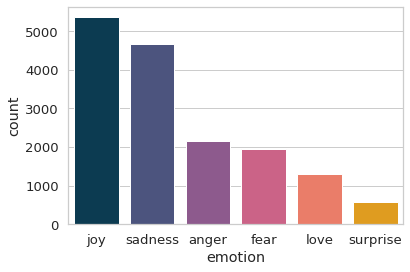

In [6]:
# @title Distribution of emotions for training
sns.countplot(x=tweet_emotions_training['emotion'], order = tweet_emotions_training['emotion'].value_counts(normalize=True).index)

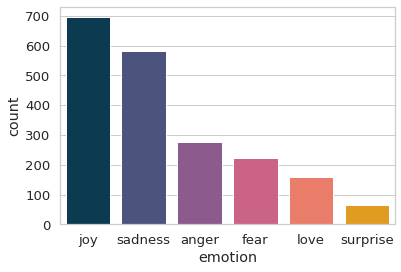

In [7]:
# @title Distribution of emotions for testing
sns.countplot(x=tweet_emotions_test['emotion'], order = tweet_emotions_test['emotion'].value_counts(normalize=True).index)

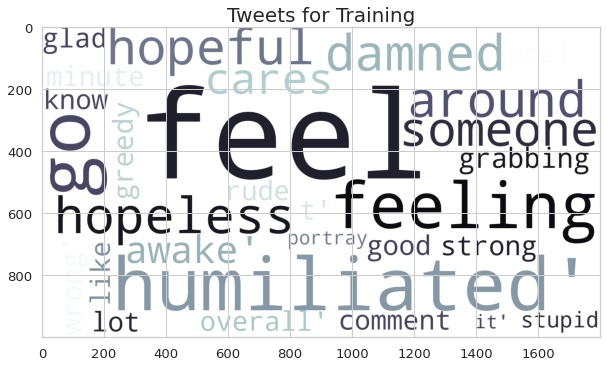

In [8]:
from wordcloud import WordCloud

def word_count(df, title):
    word_cloud = WordCloud(max_words=200,
                           background_color='white',
                           stopwords=STOP_WORDS,
                           colormap='bone',
                           height=1000,
                           width=1800)
    tweets = df.text.values
    word_cloud.generate(str(tweets).lower())
    fig = plt.figure()
    plt.imshow(word_cloud)
    fig.set_figwidth(10)
    fig.set_figheight(10)
    plt.title(title, fontdict={"fontsize": 20})
    plt.show()

word_count(data_train, "Tweets for Training")

## Feature Extraction
Convert words to numerical data and prepare features and classes for training/test

In [9]:
from sklearn.feature_extraction.text import CountVectorizer


# method to convert text to numerical data
# perform feature extraction (vectorization)
vectorizer = CountVectorizer()

vectorizer.fit(data_train["text"].values)

# text are our features
x_train_matrix = vectorizer.transform(data_train["text"].values)
x_test_matrix  = vectorizer.transform(data_test["text"].values)

x_train = x_train_matrix.toarray()
x_test = x_test_matrix.toarray()

y_train = tweet_emotions_training["label"]
y_test = tweet_emotions_test["label"]

print(f'''
  There are {x_train.shape[0]} tweets for training, and {x_test.shape[0]} for test. 
  Each with {x_train.shape[1]} features
''')


  There are 16000 tweets for training, and 2000 for test. 
  Each with 15014 features



<a name="models"></a>
# Models
Define the following models:

*   DNN (Deep Neural Network)
*   SVC (Support Vector Machine)
*   Random Forest
*   Logistic Regression

for each the training phase is carried out.

<a name="deep_learning"></a>
## Deep Learning

In [10]:
#@title **Definition of the DNN model**
from keras.models import Sequential
from keras import layers

model = Sequential([
  layers.Flatten( input_dim=x_train.shape[1]),
  layers.Dense(32, activation=tf.nn.relu),
  layers.Dense(128, activation=tf.nn.relu),
  layers.Dropout(0.4),
  layers.Dense(NUM_CLASSES, activation=tf.nn.softmax)
])

# evita overfitting al deterner el entrenamiento cuando el validation loss empieza
# a crecer demasiado

model.compile(
  optimizer=tf.keras.optimizers.Adam(learning_rate=0.00005), 
  loss='sparse_categorical_crossentropy',
  metrics=['accuracy']
)
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten (Flatten)           (None, 15014)             0         
                                                                 
 dense (Dense)               (None, 32)                480480    
                                                                 
 dense_1 (Dense)             (None, 128)               4224      
                                                                 
 dropout (Dropout)           (None, 128)               0         
                                                                 
 dense_2 (Dense)             (None, 6)                 774       
                                                                 
Total params: 485,478
Trainable params: 485,478
Non-trainable params: 0
_________________________________________________________________


In [11]:
#@title Entrenamiento { display-mode: "form" }
epochs = 10#@param {type:"number"}
batch_size = 32#@param {type:"number"}

dnn_training_history = model.fit(
  x_train, 
  y_train, 
  epochs=epochs, 
  batch_size=batch_size,
  verbose=True,
  validation_data=(x_test, y_test),
)

Epoch 1/10
500/500 [==============================] - 9s 9ms/step - loss: 1.7430 - accuracy: 0.3126 - val_loss: 1.6472 - val_accuracy: 0.3525
Epoch 2/10
500/500 [==============================] - 4s 8ms/step - loss: 1.5892 - accuracy: 0.3825 - val_loss: 1.5293 - val_accuracy: 0.4430
Epoch 3/10
500/500 [==============================] - 4s 7ms/step - loss: 1.4914 - accuracy: 0.4856 - val_loss: 1.4285 - val_accuracy: 0.5440
Epoch 4/10
500/500 [==============================] - 2s 5ms/step - loss: 1.3462 - accuracy: 0.5667 - val_loss: 1.2817 - val_accuracy: 0.5860
Epoch 5/10
500/500 [==============================] - 2s 5ms/step - loss: 1.1619 - accuracy: 0.6214 - val_loss: 1.1200 - val_accuracy: 0.6425
Epoch 6/10
500/500 [==============================] - 2s 5ms/step - loss: 0.9765 - accuracy: 0.6977 - val_loss: 0.9642 - val_accuracy: 0.7125
Epoch 7/10
500/500 [==============================] - 3s 5ms/step - loss: 0.8048 - accuracy: 0.7809 - val_loss: 0.8315 - val_accuracy: 0.7690
Epoch 

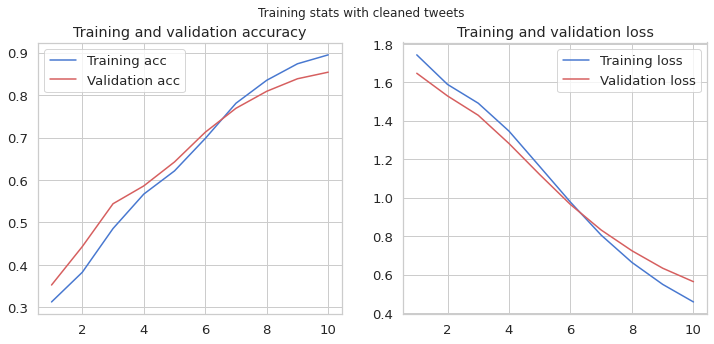

In [12]:
plot_history(dnn_training_history, title="Training stats with cleaned tweets")

## Other Machine Learning Algorithms

<a name="svc"></a>
### Support Vector Machine

In [13]:
from sklearn.svm import SVC as SupportVectorMachine

kernel = "rbf"#@param {type:"string"}
degree = 5#@param {type:"number"}
SVC = SupportVectorMachine(kernel=kernel, degree=degree)

SVC.fit(x_train_matrix, y_train)

SVC(degree=5)

<a name="rf"></a>
### Random Forest

In [14]:
from sklearn.ensemble import RandomForestClassifier

max_depth = 50#@param {type:  "number"}
n_estimators = 150#@param {type:  "number"}
RF = RandomForestClassifier(max_depth=max_depth, n_estimators=n_estimators)

RF.fit(x_train, y_train)

RandomForestClassifier(max_depth=50, n_estimators=150)

In [16]:
# predictions with Random Forest
from sklearn.metrics import accuracy_score
predictions = RF.predict(x_test_matrix)
perf = accuracy_score(y_test, predictions)

print(f"Performance with Random Forest: {round(perf, 4)}")

Performance with Random Forest: 0.7225


In [17]:
import operator
from collections import OrderedDict

imap = {}
for word, importance in zip(vectorizer.vocabulary_.keys(), RF.feature_importances_):
  imap[word] = importance

sort_imap = sorted(imap, key=imap.get, reverse=True)

In [18]:
N_WORDS = 15
for word in sort_imap[:N_WORDS]:
  print(f"• {word}")

• weismans
• fed
• blowout
• manage
• dies
• prepared
• dialog
• softer
• rockette
• cooperati
• eventual
• knwing
• awkwardly
• blogstalkers
• filed


<a name="lr"></a>
### Logistic Regression

In [19]:
from sklearn.linear_model import LogisticRegression

LR = LogisticRegression(max_iter=1000, multi_class='multinomial', solver='lbfgs')
LR.fit(x_train_matrix, y_train)

LogisticRegression(max_iter=1000, multi_class='multinomial')

<a name="testing_predictions"></a>
# Testing and Predictions

In [20]:
#@title Random Forest and Support Vector Machine
from sklearn.metrics import accuracy_score, make_scorer, mean_squared_error, mean_absolute_error
from sklearn.model_selection import train_test_split, cross_val_score, KFold
from sklearn.model_selection import KFold, cross_val_score

# predictions with Random Forest
predictions = RF.predict(x_test_matrix)
perf = accuracy_score(y_test, predictions)

print(f"Performance with Random Forest: {round(perf, 4)}")


# predictions with Support Vector Machine
predictions = SVC.predict(x_test_matrix)
perf = accuracy_score(y_test, predictions)

print(f"Performance with Support Vector Machine: {round(perf, 4)}")

predictions = LR.predict(x_test_matrix)
perf = accuracy_score(y_test, predictions)
print(f"Performance with Logistic Regressor: {round(perf, 4)}")

Performance with Random Forest: 0.7225
Performance with Support Vector Machine: 0.803
Performance with Logistic Regressor: 0.8845


63/63 [==============================] - 0s 4ms/step - loss: 0.5629 - accuracy: 0.8540
DNN training Accuracy: 0.9168
DNN testing Accuracy:  0.8540


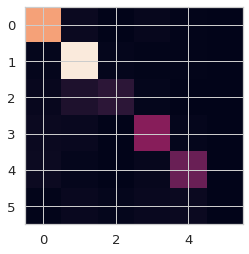

In [21]:
#@title Deep Neural Network
from sklearn.metrics import confusion_matrix

# check to detect overfitting/underfitting
train_loss, train_acc = model.evaluate(x_train, y_train, verbose=False)
test_loss, test_acc = model.evaluate(x_test, y_test)

print("DNN training Accuracy: {:.4f}".format(train_acc))
print("DNN testing Accuracy:  {:.4f}".format(test_acc))

predictions = model.predict(x_test)

labels_pred = np.argmax(predictions, axis=1)
cm_test = confusion_matrix(y_test, labels_pred)
plt.imshow(cm_test)

<a name="playground"></a>
# Playground

In [22]:
#@title Enter your tweet for emotion extraction!
input_tweet = "This is such a great day, I am being very productive"#@param {type:"string"}

processed_tweet = clean_tweet(input_tweet)

x_predict = vectorizer.transform([processed_tweet])
predictions = model.predict(x_predict.toarray())

emotion_lbl = np.argmax(predictions, axis=1)[0]
emotion = EMOTIONS_MAP[emotion_lbl]
print(f"The input tweet transmits mainly: {emotion} ({to_percent(predictions[0][emotion_lbl], 1)}%). It's followed by: \n")
indexes_higher_emotions = np.flip(np.argsort(predictions))[0]

for index in indexes_higher_emotions[1:3]:
  emotion = EMOTIONS_MAP[index]
  print(f" - {emotion}: {to_percent(predictions[0][index], 1)}%")

emotion_lbl = LR.predict(x_predict)[0]
emotion = EMOTIONS_MAP[emotion_lbl]
print(f"\nExtra: Prediction with Logistic Regressor: {emotion}")


The input tweet transmits mainly: joy (92.2%). It's followed by: 

 - love: 2.4%
 - anger: 2.0%

Extra: Prediction with Logistic Regressor: joy


# References

*   https://www.kaggle.com/sanikamal/text-classification-with-python-and-keras
*   https://towardsdatascience.com/analysis-of-the-emotion-data-a-dataset-for-emotion-recognition-tasks-6b8c9a5dfe57
*   https://www.kaggle.com/skrisshnaswamy/sentiment-analysis-sentiment140-l-nfs-vs-gru
